In [1]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from keras.optimizers import Adam, SGD
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from hyperopt import hp, tpe, fmin, STATUS_OK, Trials
from hyperopt.pyll.base import scope
from datetime import datetime, timedelta
import tensorflow as tf
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError, MeanSquaredError
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import plotly.express as px

## Uploading data and anomaly detection and smoothing anomalies

In [2]:
elect = pd.read_excel("hourly_electricity.xlsx")

In [3]:
elect["date"] = pd.to_datetime(elect["date"], format='%d.%m.%Y')

In [4]:
elect["time"] = elect["date"].astype(str) + " " + elect["hour"].astype(str)

In [5]:
elect["time"] = pd.to_datetime(elect["time"])
elect.sort_values(by = "time", inplace = True)

In [6]:
elect.set_index("time", inplace=True)

In [7]:
elect.drop(columns="hour", inplace = True)

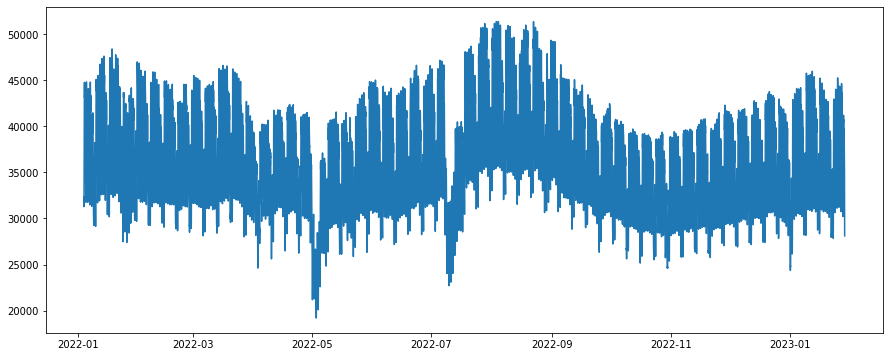

In [8]:
fig, ax = plt.subplots(figsize = (15, 6))
ax.plot(elect.index[-390*24:], elect["electricity"][-390*24:], label = "hourly  electricity consumption")
plt.show()

In [121]:
## Lets inspect the data for the last 200 days to see hourly and weekly sesonality
fig = px.line(elect[-200:], x=elect[-200:].index, y="electricity", title='Hourly electricity consumption in Turkey',)
fig.show()

c:\users\musta\appdata\local\programs\python\python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



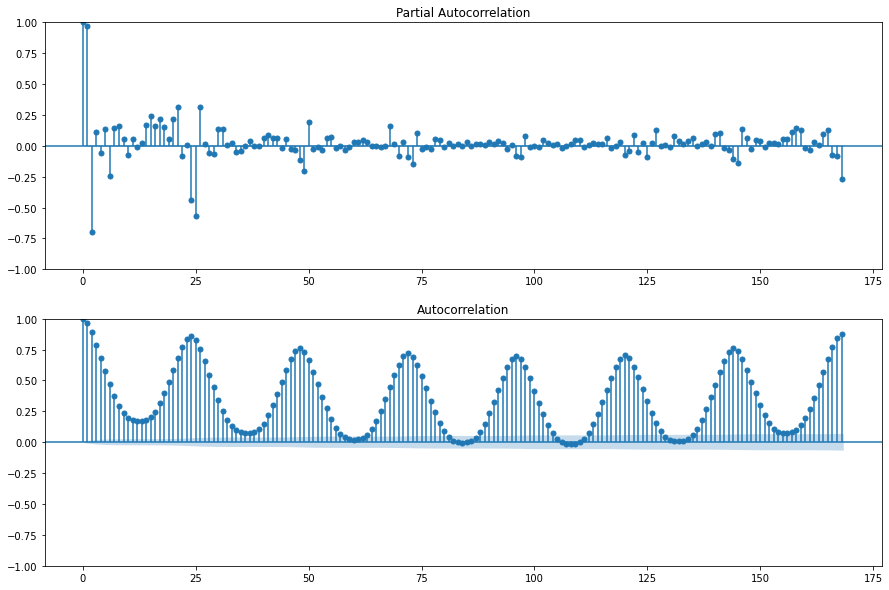

In [10]:
fig, ax = plt.subplots(2, 1, figsize = (15,10))

plot_pacf(elect["electricity"],ax = ax[0], lags = 168) # It seems that there are significant spikes until 26
plot_acf(elect["electricity"],ax = ax[1], lags = 168);

In [14]:
elect_lstm = elect.drop(columns="date")

In [284]:
#elect_lstm  = elect_lstm["2022-01-01":]

In [12]:
#elect_lstm["hour"] = elect_lstm.index.hour
#elect_lstm["week"]= elect_lstm.index.day_of_week
#elect_lstm["day"] = elect_lstm.index.day_of_year

In [22]:
#elect_lstm = pd.get_dummies(data = elect_lstm, columns=["hour", "week", "day"])

## Data Preparation for LSTM

In [102]:
elect_df = elect_lstm.copy()

### Scale data

In [103]:
#Scale data
scaler=MinMaxScaler(feature_range=(0,1))
elect_s =scaler.fit_transform(np.array(elect_df))

### Splitting dataset into train and test split

In [104]:
# splitting dataset into train and test split
len_train = len(elect_df[:"2022-12-31"])
len_test = len(elect_df["2023-01-01":])

elect_train = elect_s[:-len_test]
elect_test = elect_s[-len_test:]

## Data Preperation 

In [105]:
# creating an appropriate dataset for LSTM
#number of consecutive time steps in a time series that are considered as input for the LSTM

def create_input_data(data, time_step):
    X, Y = [], []
    for i in range(len(data)-time_step-1):
        # a = np.concatenate((data[i:i+time_step, 0], data[(i+time_step), 1:])) #### subset i to time step row and 0th column and concaneate additional features
        a = np.array(data[i:i+time_step, 0]) ### subset i to time step row and 0th column.
        X.append(a)
        Y.append(data[(i+time_step), 0])
    return np.array(X), np.array(Y)

In [110]:
# reshape into X=t,t+1,t+2,t+3,...t+30 and Y=t+30
time_step = 24
X_train, Y_train = create_input_data(elect_train, time_step)
X_test, Y_test = create_input_data(elect_test, time_step)

In [111]:
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((52415, 168), (52415,), (505, 168), (505,))

In [112]:
# Reshape from [samples, timesteps] to [samples, timesteps, features]--> converting from 2D to 3D
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1] , 1)

In [113]:
X_train.shape, X_test.shape

((52415, 168, 1), (505, 168, 1))

## Modeling the data

In [119]:
### Create the Stacked LSTM model
model=Sequential()
model.add(LSTM(100,return_sequences=True, input_shape=(24,1)))
model.add(Dropout(0.2))
model.add(LSTM(100,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1))

#optimizer = SGD(learning_rate=0.3, decay = 0.01, momentum =0.9)
optimizer = SGD(learning_rate=0.2, momentum =0.9)
model.compile(loss='mean_squared_error',optimizer=optimizer, metrics=[RootMeanSquaredError(), MeanAbsoluteError()])

In [120]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_15 (LSTM)              (None, 24, 100)           40800     
                                                                 
 dropout_15 (Dropout)        (None, 24, 100)           0         
                                                                 
 lstm_16 (LSTM)              (None, 24, 100)           80400     
                                                                 
 dropout_16 (Dropout)        (None, 24, 100)           0         
                                                                 
 lstm_17 (LSTM)              (None, 50)                30200     
                                                                 
 dropout_17 (Dropout)        (None, 50)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                

### Fitting the model

In [117]:
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_root_mean_squared_error', mode='min',patience=25)
lr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_root_mean_squared_error', patience=10,factor = 0.4)

In [118]:
model.fit(X_train,Y_train, validation_data=(X_test,Y_test),epochs=400,batch_size=64,verbose=1,callbacks = [lr_callback, es_callback])

Epoch 1/400
340/819 [===========>..................] - ETA: 4:33 - loss: 0.0197 - root_mean_squared_error: 0.1402 - mean_absolute_error: 0.1116


KeyboardInterrupt



In [381]:

time_step =24
temp_input = elect_train[-time_step:, 0].tolist() # last 30 days of the train data

In [384]:
x_input=np.array(temp_input)

## Predictions for tnext N hours/days

In [91]:

time_step =24
temp_input = elect_train[-time_step:, 0].tolist() # last 30 days of the train data
x_input=np.array(temp_input)

#x_input = np.concatenate((elect_train[-time_step:, 0], elect_train[0, 1:]))#first input data

last_output=[]
n_steps= len_test
i=0
while(i<n_steps):
    
    if(len(temp_input)>time_step):
        x_input=np.array(temp_input[1:])
        #x_input = np.concatenate((np.array(temp_input[1:]), elect_test[i, 1:]))
        x_input = x_input.reshape((1, 24, 1))
        yhat = model.predict(x_input, verbose=0)

        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        print("forecast "+ str(i) + " with the last "+str(len(temp_input)))
        last_output.extend(yhat.tolist())
        i=i+1
    else:
        #x_input = np.concatenate((elect_train[-time_step:, 0], elect_test[i, 1:]))
        x_input = x_input.reshape((1, 24,1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        print("forecast "+ str(i) + " with the last "+str(len(temp_input)))
        last_output.extend(yhat.tolist())
        i=i+1
    

print(last_output) 

forecast 0 with the last 25
forecast 1 with the last 25
forecast 2 with the last 25
forecast 3 with the last 25
forecast 4 with the last 25
forecast 5 with the last 25
forecast 6 with the last 25
forecast 7 with the last 25
forecast 8 with the last 25
forecast 9 with the last 25
forecast 10 with the last 25
forecast 11 with the last 25
forecast 12 with the last 25
forecast 13 with the last 25
forecast 14 with the last 25
forecast 15 with the last 25
forecast 16 with the last 25
forecast 17 with the last 25
forecast 18 with the last 25
forecast 19 with the last 25
forecast 20 with the last 25
forecast 21 with the last 25
forecast 22 with the last 25
forecast 23 with the last 25
forecast 24 with the last 25
forecast 25 with the last 25
forecast 26 with the last 25
forecast 27 with the last 25
forecast 28 with the last 25
forecast 29 with the last 25
forecast 30 with the last 25
forecast 31 with the last 25
forecast 32 with the last 25
forecast 33 with the last 25
forecast 34 with the las

forecast 278 with the last 25
forecast 279 with the last 25
forecast 280 with the last 25
forecast 281 with the last 25
forecast 282 with the last 25
forecast 283 with the last 25
forecast 284 with the last 25
forecast 285 with the last 25
forecast 286 with the last 25
forecast 287 with the last 25
forecast 288 with the last 25
forecast 289 with the last 25
forecast 290 with the last 25
forecast 291 with the last 25
forecast 292 with the last 25
forecast 293 with the last 25
forecast 294 with the last 25
forecast 295 with the last 25
forecast 296 with the last 25
forecast 297 with the last 25
forecast 298 with the last 25
forecast 299 with the last 25
forecast 300 with the last 25
forecast 301 with the last 25
forecast 302 with the last 25
forecast 303 with the last 25
forecast 304 with the last 25
forecast 305 with the last 25
forecast 306 with the last 25
forecast 307 with the last 25
forecast 308 with the last 25
forecast 309 with the last 25
forecast 310 with the last 25
forecast 3

forecast 552 with the last 25
forecast 553 with the last 25
forecast 554 with the last 25
forecast 555 with the last 25
forecast 556 with the last 25
forecast 557 with the last 25
forecast 558 with the last 25
forecast 559 with the last 25
forecast 560 with the last 25
forecast 561 with the last 25
forecast 562 with the last 25
forecast 563 with the last 25
forecast 564 with the last 25
forecast 565 with the last 25
forecast 566 with the last 25
forecast 567 with the last 25
forecast 568 with the last 25
forecast 569 with the last 25
forecast 570 with the last 25
forecast 571 with the last 25
forecast 572 with the last 25
forecast 573 with the last 25
forecast 574 with the last 25
forecast 575 with the last 25
forecast 576 with the last 25
forecast 577 with the last 25
forecast 578 with the last 25
forecast 579 with the last 25
forecast 580 with the last 25
forecast 581 with the last 25
forecast 582 with the last 25
forecast 583 with the last 25
forecast 584 with the last 25
forecast 5

In [92]:
actual_y = np.array(elect_df["electricity"]).reshape(-1,1)

In [93]:
scaler_p =MinMaxScaler(feature_range=(0,1))
actual_y_s =scaler_p.fit_transform(actual_y)

In [94]:
scaled_preds = np.array(last_output)

### Accuracy (MAPE)

In [95]:
unscaled_preds = scaler_p.inverse_transform(scaled_preds)

In [96]:
test = pd.DataFrame(elect_lstm["2023-01-01":]["electricity"])

In [97]:
test["forecast"]=unscaled_preds

In [98]:
test["mape"] = abs(test["forecast"] - test["electricity"])*100/test["electricity"]

In [101]:
test

,electricity,forecast,mape
time,,,
2023-01-01 00:00:00,28816.55,14297.799110,50.383377
2023-01-01 01:00:00,27589.25,14302.092067,48.160635
2023-01-01 02:00:00,26328.82,14317.115432,45.621887
2023-01-01 03:00:00,25224.40,14345.633734,43.127949
2023-01-01 04:00:00,24636.46,14387.504930,41.600762
...,...,...,...
2023-01-28 21:00:00,37362.01,15333.300000,58.960184
2023-01-28 22:00:00,36376.15,15333.300000,57.847931
2023-01-28 23:00:00,35105.99,15333.300000,56.322838


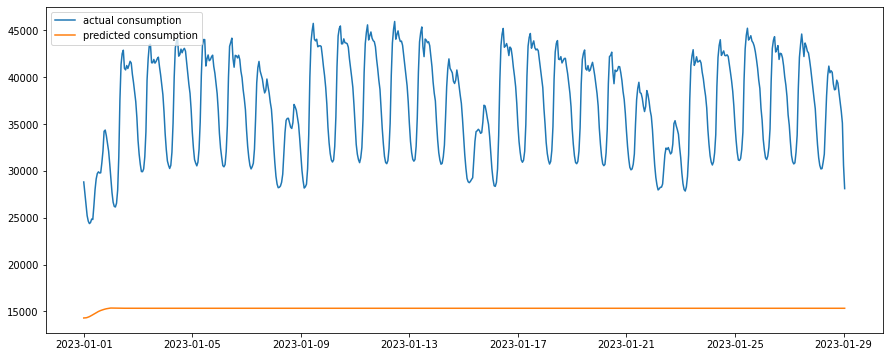

In [100]:
fig, ax = plt.subplots(figsize = (15,6))
ax.plot(test.index, test["electricity"], label = "actual consumption", color = "C0")
ax.plot(test.index, test["forecast"], label = "predicted consumption", color = "C1")
plt.legend(loc="upper left")
plt.show()

## Hyperparameter Tuning of LSTM with Hyperopt

In [ ]:
#quniform returns float, some parameters require int; use this to force int
space = {'learning_rate'       : hp.uniform('learning_rate',0.001, 0.5),
        'rate'       : hp.uniform('rate',0.01, 0.5),
         'units'      : scope.int(hp.quniform('units',10,150,5)),
         'batch_size' :scope.int(hp.quniform('batch_size',24,336,24)),
         'layers'     : scope.int(hp.quniform('layers',1,6,1)),
        }

In [ ]:
def objective(space):
    model = Sequentialuential()
    if space["layes"] == 1:
        model.add(LSTM(units=space["units"], return_sequences = True, input_shape = (172,1)))
        model.add(rate = Dropout(space["rate"]))
    else:
        # First layer specifies input_shape and returns sequences
        model.add(LSTM(units=space["units"], return_sequences = True, input_shape = (172,1)))
        model.add(rate = Dropout(space["rate"]))
        # Middle layers return sequences
        for i in range(space["layers"]):
            model.add(units=LSTM(space["units"], return_sequences = True))
            model.add(rate = Dropout(space["rate"]))
        # Last layer doesn't return anything
        model.add(LSTM(units=space['units']))
        model.add(Dropout(rate=space['rate']))
    model.add(Dense(1))
    optimizer = Adam(learning_rate=space["learning_rate"])
    model.compile(loss='mean_squared_error',optimizer=optimizer, metrics=[RootMeanSquaredError(), MeanAbsoluteError()])
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_root_mean_squared_error', mode='min',patience=15)
    history = model.fit(X_train,Y_train, validation_data=(X_test,Y_test),epochs=300,
                        batch_size=space["batch_size"],verbose=0,callbacks = [es_callback])
    # Get the lowest validation loss of the training epochs
    validation_loss = np.amin(result.history['val_loss']) 
    print('Best validation loss of epoch:', validation_loss)
    
    return {'loss': validation_loss, 
            'status': STATUS_OK, 
            'model': model, 
            'params': space}

In [ ]:
trials = Trials()
best = fmin(objective, 
            space, 
            algo=tpe.suggest,
            max_evals=100,
            trials=trials)

In [ ]:
best_model = trials.results[np.argmin([r['loss'] for r in 
    trials.results])]['model']
best_params = trials.results[np.argmin([r['loss'] for r in 
    trials.results])]['params']